# ✍️🧮❤️ Models + Data

We work so hard to gather sensitive observations, calibrate them carefully, and make precise measurements from them to construct reliable datasets. How do we go from those data to learning about objects or processes? 

What's the size of that planet, the distance to that supernova, the age of that cluster, the temperature of that gas? Sometimes it's one obvious measurement, but often we need to fit theoretical models to real data to find out.

This notebook provide a very brief whirlwind perspective on how to fit models to data. We make lots of assumptions and hide lots of caveats, but we try to show general principles for finding good models.

In [2]:
import matplotlib.pyplot as plt, numpy as np
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (8,3)
from IPython.display import Image
from astropy.io import ascii

ModuleNotFoundError: No module named 'matplotlib'

# The Data
Let's play with an historically important dataset, the 25 pulsation periods and apparent magnitudes going into the first "Leavitt Law" period-luminosity relationship of Cepheid variable stars ([Leavitt & Pickering 1912](https://ui.adsabs.harvard.edu/abs/1912HarCi.173....1L/abstract)).

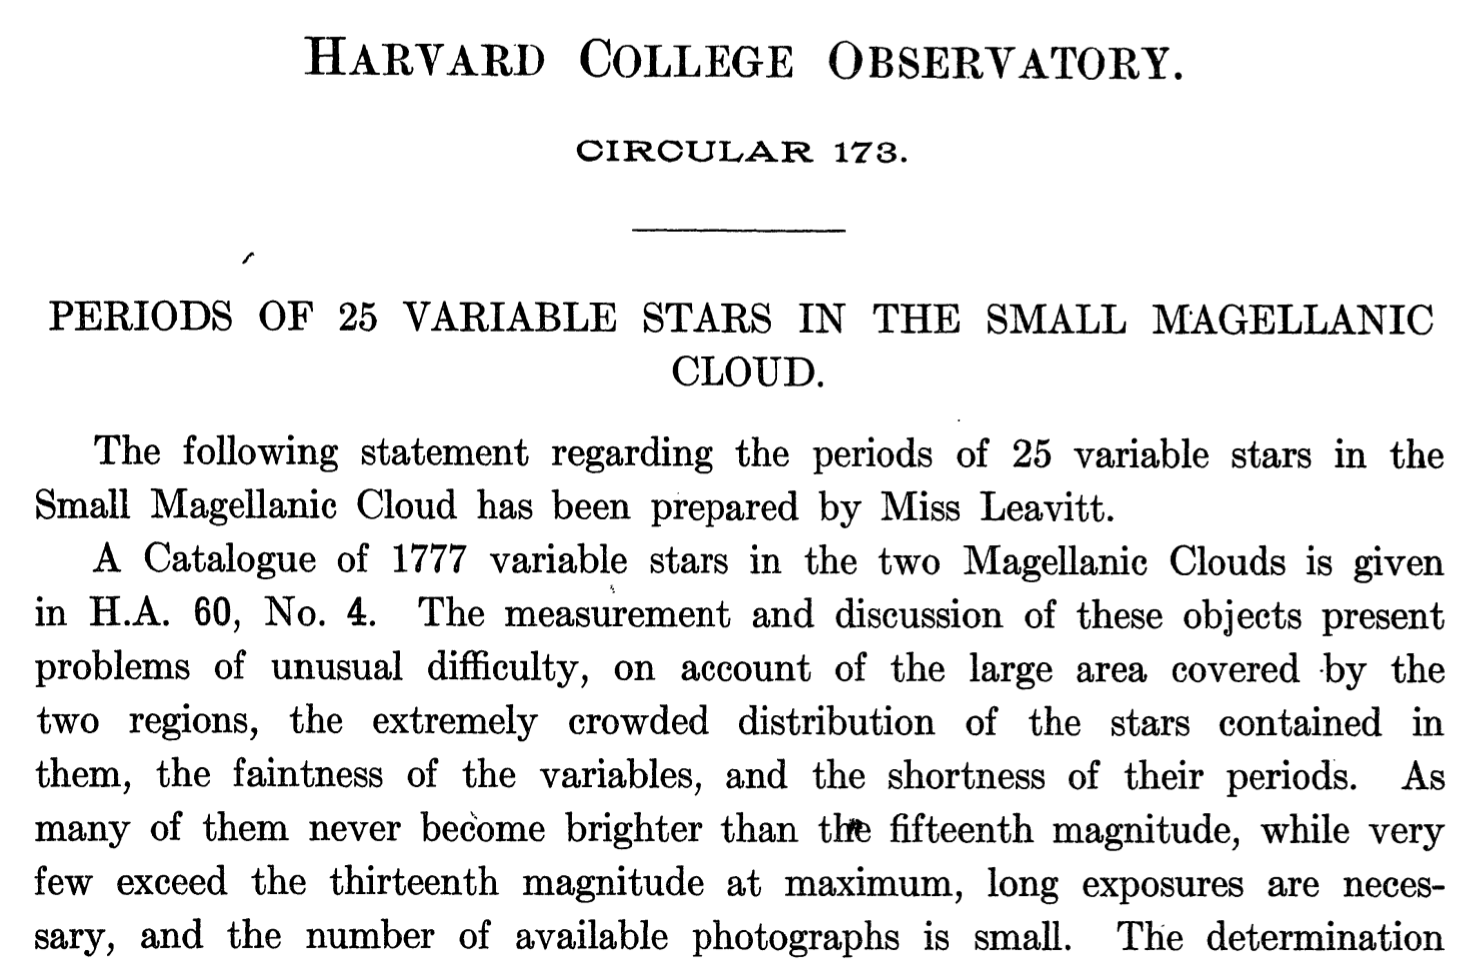

In [28]:
Image('leavitt-text.png')

In [29]:
table = ascii.read('leavitt-periods.csv')
table

star_number,max_magnitude,min_magnitude,epoch,period
int64,float64,float64,float64,float64
1505,14.8,16.1,0.02,1.25336
1436,14.8,16.4,0.02,1.6637
1446,14.8,16.4,1.38,1.762
1506,15.1,16.3,1.08,1.87502
1413,14.7,15.6,0.35,2.17352
1460,14.4,15.7,0.0,2.913
1422,14.7,15.9,0.6,3.501
842,14.6,16.1,2.61,4.2897
1425,14.3,15.3,2.8,4.547


Let's simplify these into "x" and "y" quantities we'll try to visualize and fit. For fitting, we'll say that the independent variable $x$ is $\log_{10}$(pulsation period) and the dependent variable $y$ is the star's apparent magnitude.

In [102]:
log_period = np.log10(table['period'])
magnitude = 0.5*(table['min_magnitude'] + table['max_magnitude'])
magnitude_uncertainty = 0.2

Let's plot those data, with no model yet. (We'll put the plotting in a function so we can reuse it later.)

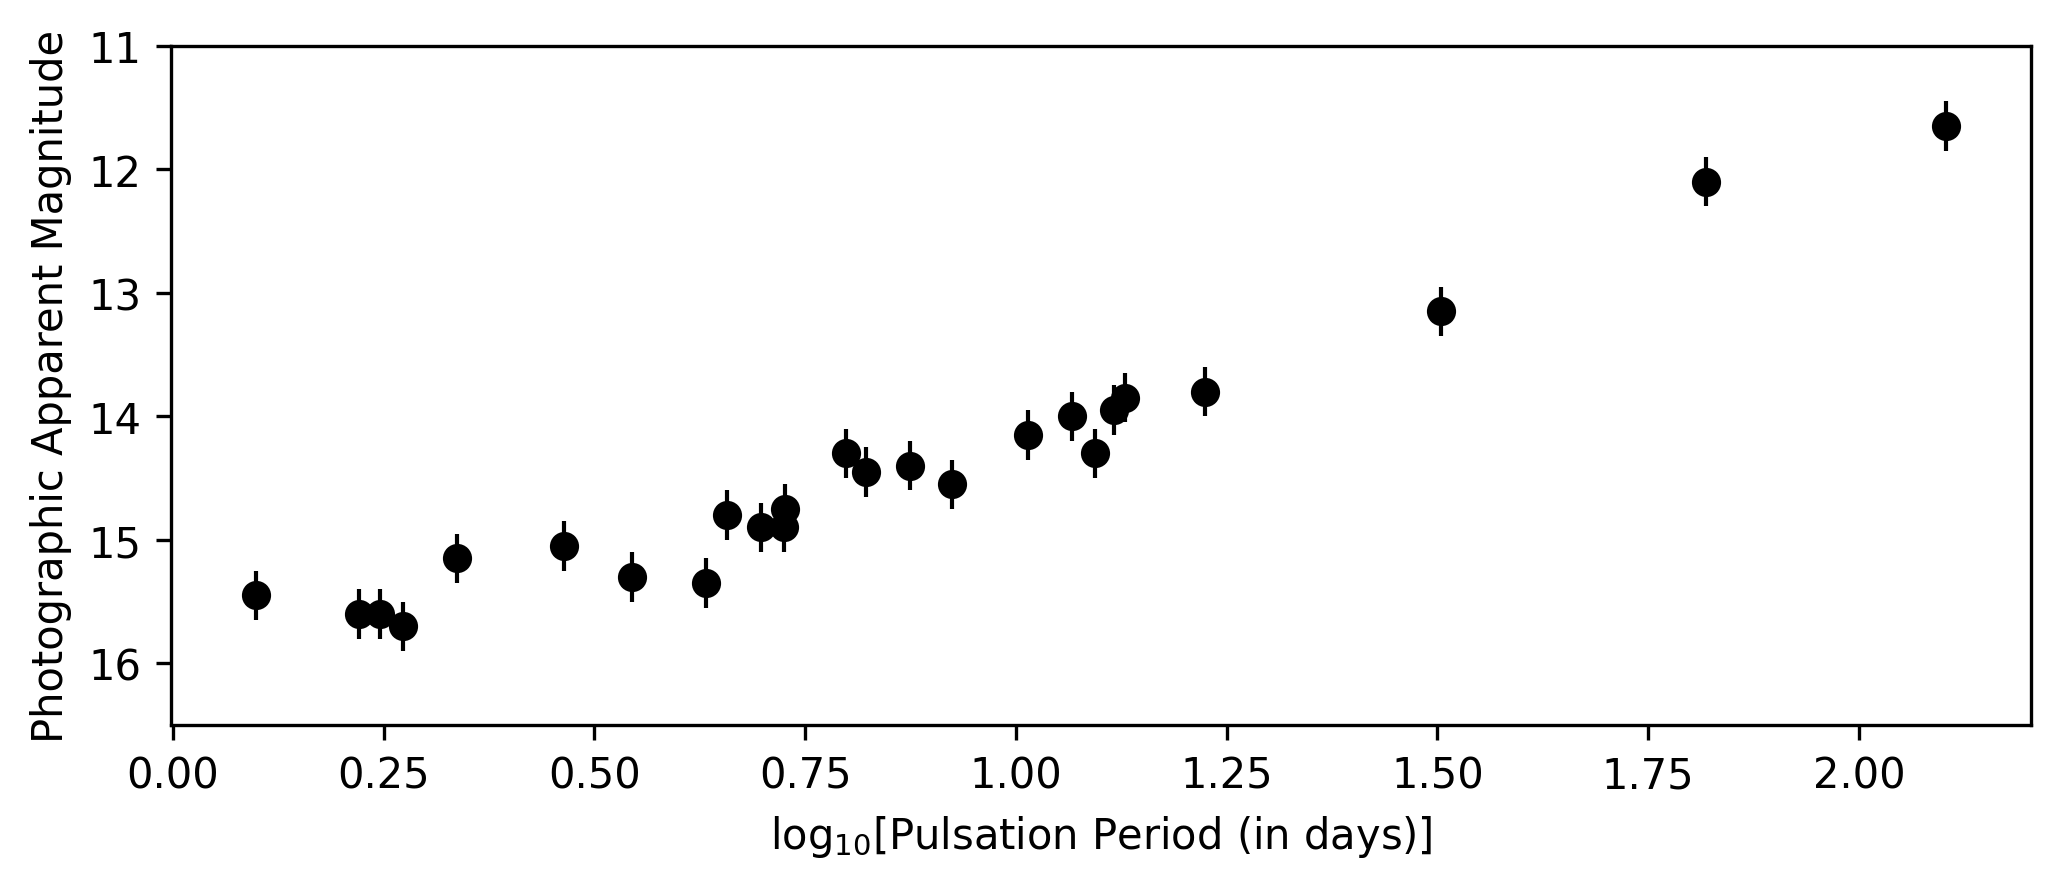

In [103]:
def plot_data():
    '''
    Plot the data by itself.
    '''
    plt.errorbar(log_period, magnitude, magnitude_uncertainty, 
                 linewidth=0, elinewidth=1, color='black', marker='o')
    plt.ylim(16.5, 11)
    plt.xlabel('log$_{10}$[Pulsation Period (in days)]'); plt.ylabel('Photographic Apparent Magnitude');
plot_data()

# The Model

Let's start with a very simple model: a straight line. 
$$ y_{\rm model}(x) = a + bx $$
The model has two parameters, $a$ for the intercept and $b$ for the slope. We can evaluate this 

In [57]:
def model(x, a, b):
    '''
    This function takes the log10(period) as an independent variable  
    and two parameters (a = intercept, b = slope), and it returns 
    model values for the apparent magnitude of the star.
    '''
    return a + b*x

Let's plot the model, for some set of parameters, with no data. (We'll put the plotting in a function so we can reuse it later.)

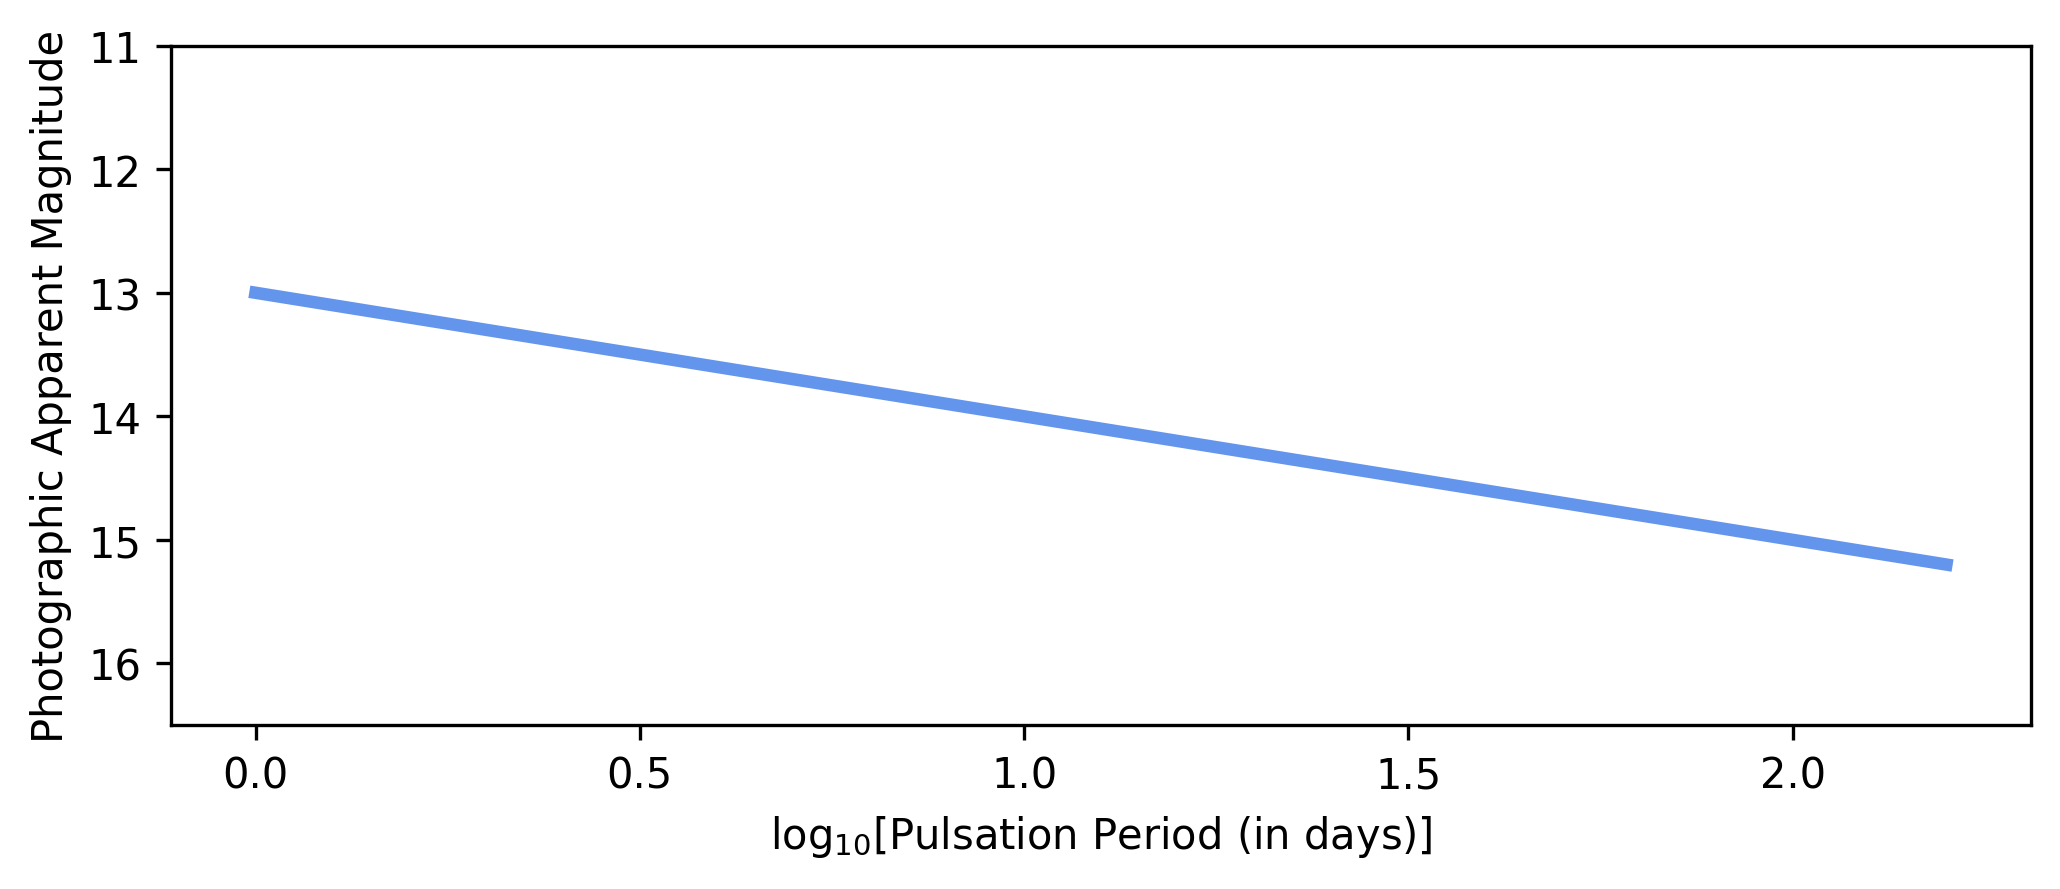

In [67]:
def plot_model(a=13, b=1):
    '''
    Plot the model by itself.
    '''
    grid_of_log_periods = np.linspace(0, 2.2)
    model_magnitudes = model(grid_of_log_periods, a, b)

    plt.plot(grid_of_log_periods, model_magnitudes, color='cornflowerblue', linewidth=3)
    plt.ylim(16.5, 11)
    plt.xlabel('log$_{10}$[Pulsation Period (in days)]'); plt.ylabel('Photographic Apparent Magnitude');
plot_model()

# Comparing Model and Data

Our eyes are pretty good at figuring out what good and bad models would look like. Let's start by plotting the data and the model together, and seeing how they look.

In [141]:
def plot_data_and_model(a=13, b=1):
    '''
    This plots both the data and the model (and gives it a title).
    '''
    plot_data()
    plot_model(a, b)
    plt.title(r'$y_{model} = a + bx$' + f' = {a:.2f}{b:+.2f}$x$')


One way to figure out reasonable parameters for our model is to fiddle with them by hand.

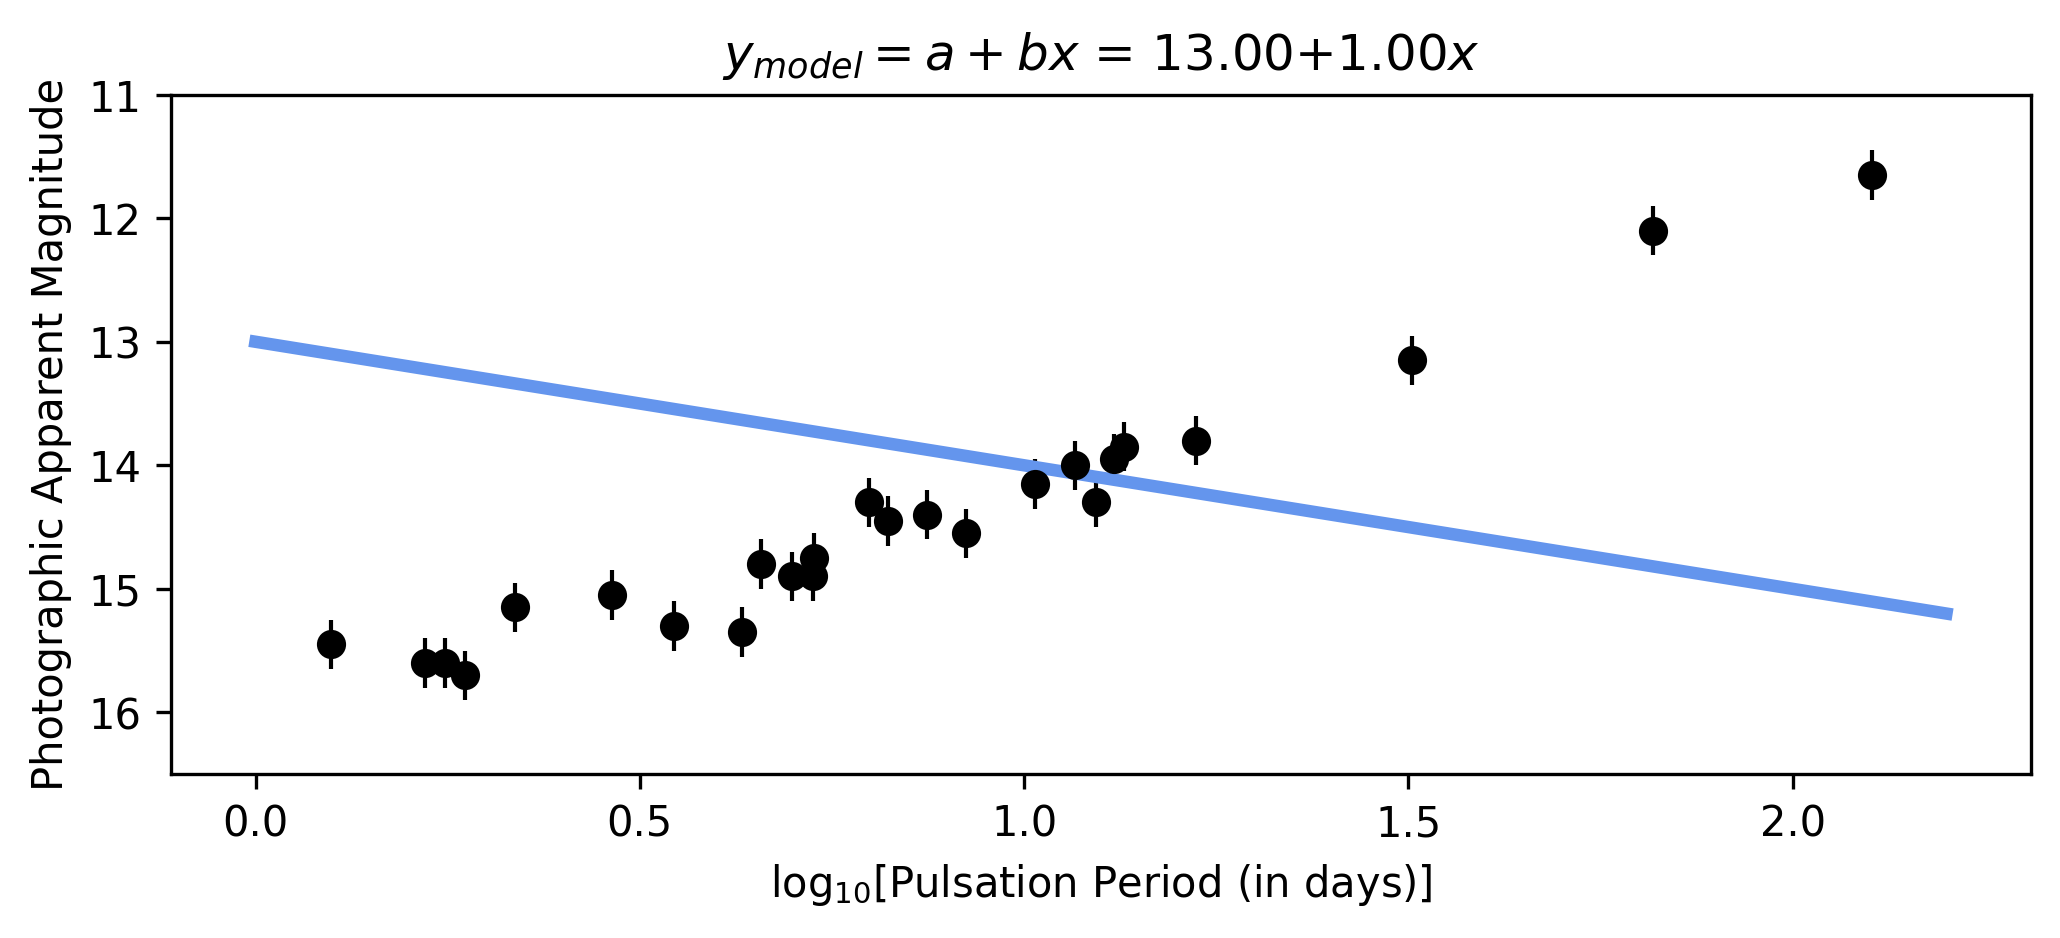

In [142]:
plot_data_and_model(a=13, b=1)

But for various reasons that feels like not a great general method.

Fortunately, we can write down a function describing the probability density of the parameters $p(a,b)$. With this function, we can determine:
+ the values of $a$ and $b$ that maximize the PDF (the "maximum likelihood estimates"). We might think of these as our "best-fit" values.
+ the range of values that fall within some probability confidence interval of those best-fit values. We could use this range to summarize the uncertainty on those parameters.


Let's write functions to calculate the $\chi^2$ ("chi-squared").

In [143]:
def calculate_chisq(a, b):
    '''
    Return the value of chi-squared for given a and b.
    '''
    y = magnitude
    ymodel = model(log_period, a, b)
    sigma = magnitude_uncertainty
    return np.sum(((y-ymodel)/sigma)**2)

Let's redefine our plotting function to also show the $\chi^2$ values now too:

In [144]:
def plot_data_and_model(a=13, b=1):
    '''
    This plots both the data and the model (and gives it a title).
    '''
    plot_data()
    plot_model(a, b)
    chisq = calculate_chisq(a,b)
    plt.title(r'$y_{model} = a + bx$' + f' = {a:.2f}{b:+.2f}$x$ | $\chi^2$={chisq:.1f}')

We can tell that $\chi^2$ is a useful quantitative figure of merit. It gets smaller if our model get's closer!

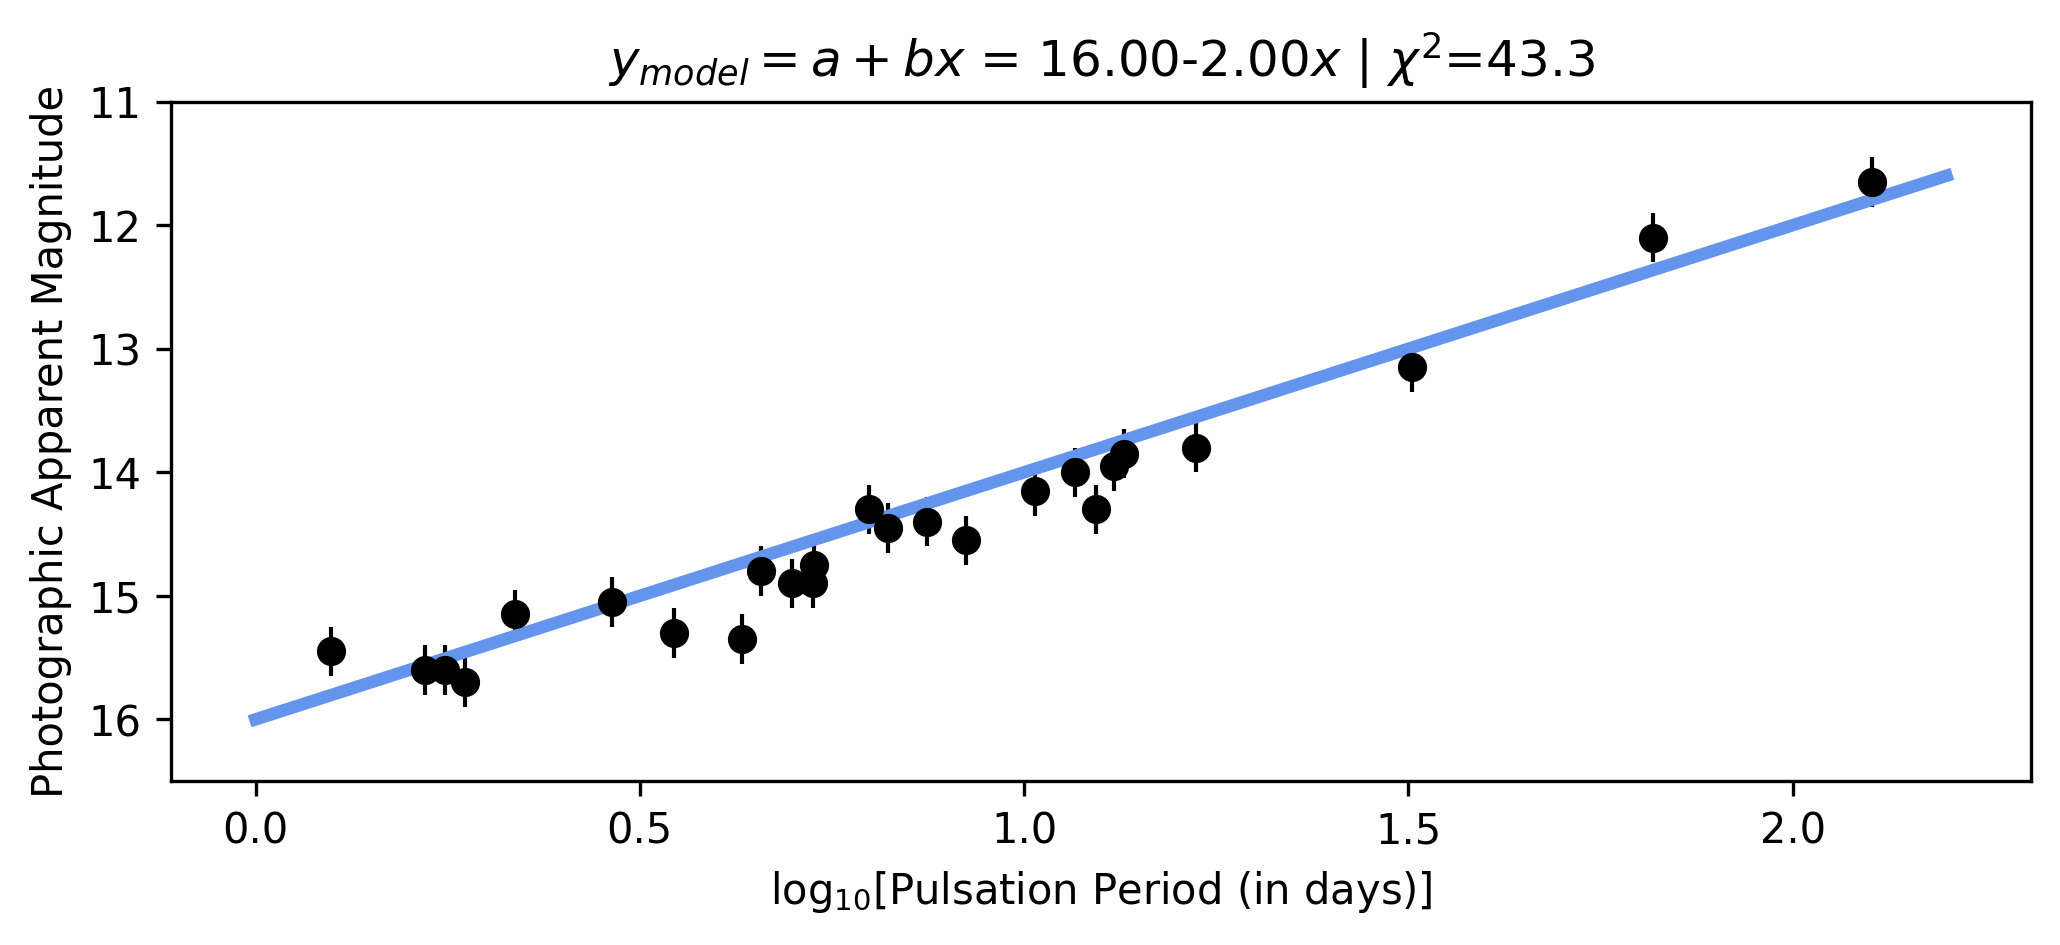

In [145]:
plot_data_and_model(a=16, b=-2)

Let's make a map of $\chi^2(a,b)$ over lots of values of $a$ and $b$.

In [169]:
res = 100
a_explore = np.linspace(17,15,res)
b_explore = np.linspace(-3, -1, res)
chisq = np.zeros((res,res))

# loop through a 2D grid of a and b
for i, a_test in enumerate(a_explore):
    for j, b_test in enumerate(b_explore):
        chisq[i,j] = calculate_chisq(a_test, b_test)

What values of $a$ and $b$ minimize our `chisq` array?

In [170]:
# let's pull out where the chi-squared is minimized
best = np.argmin(chisq)
# convert a 1D index to 2d indices
i_best, j_best = np.unravel_index(best, chisq.shape)
# pull out the best-fit values of a and b from the grid
a_best, b_best = a_explore[i_best], b_explore[j_best]
# print out that best-fit
print(f'a={a_best:.3}, b={b_best:.3} give the lowest chi-squared and highest log(likelihood)')

a=16.2, b=-2.03 give the lowest chi-squared and highest log(likelihood)


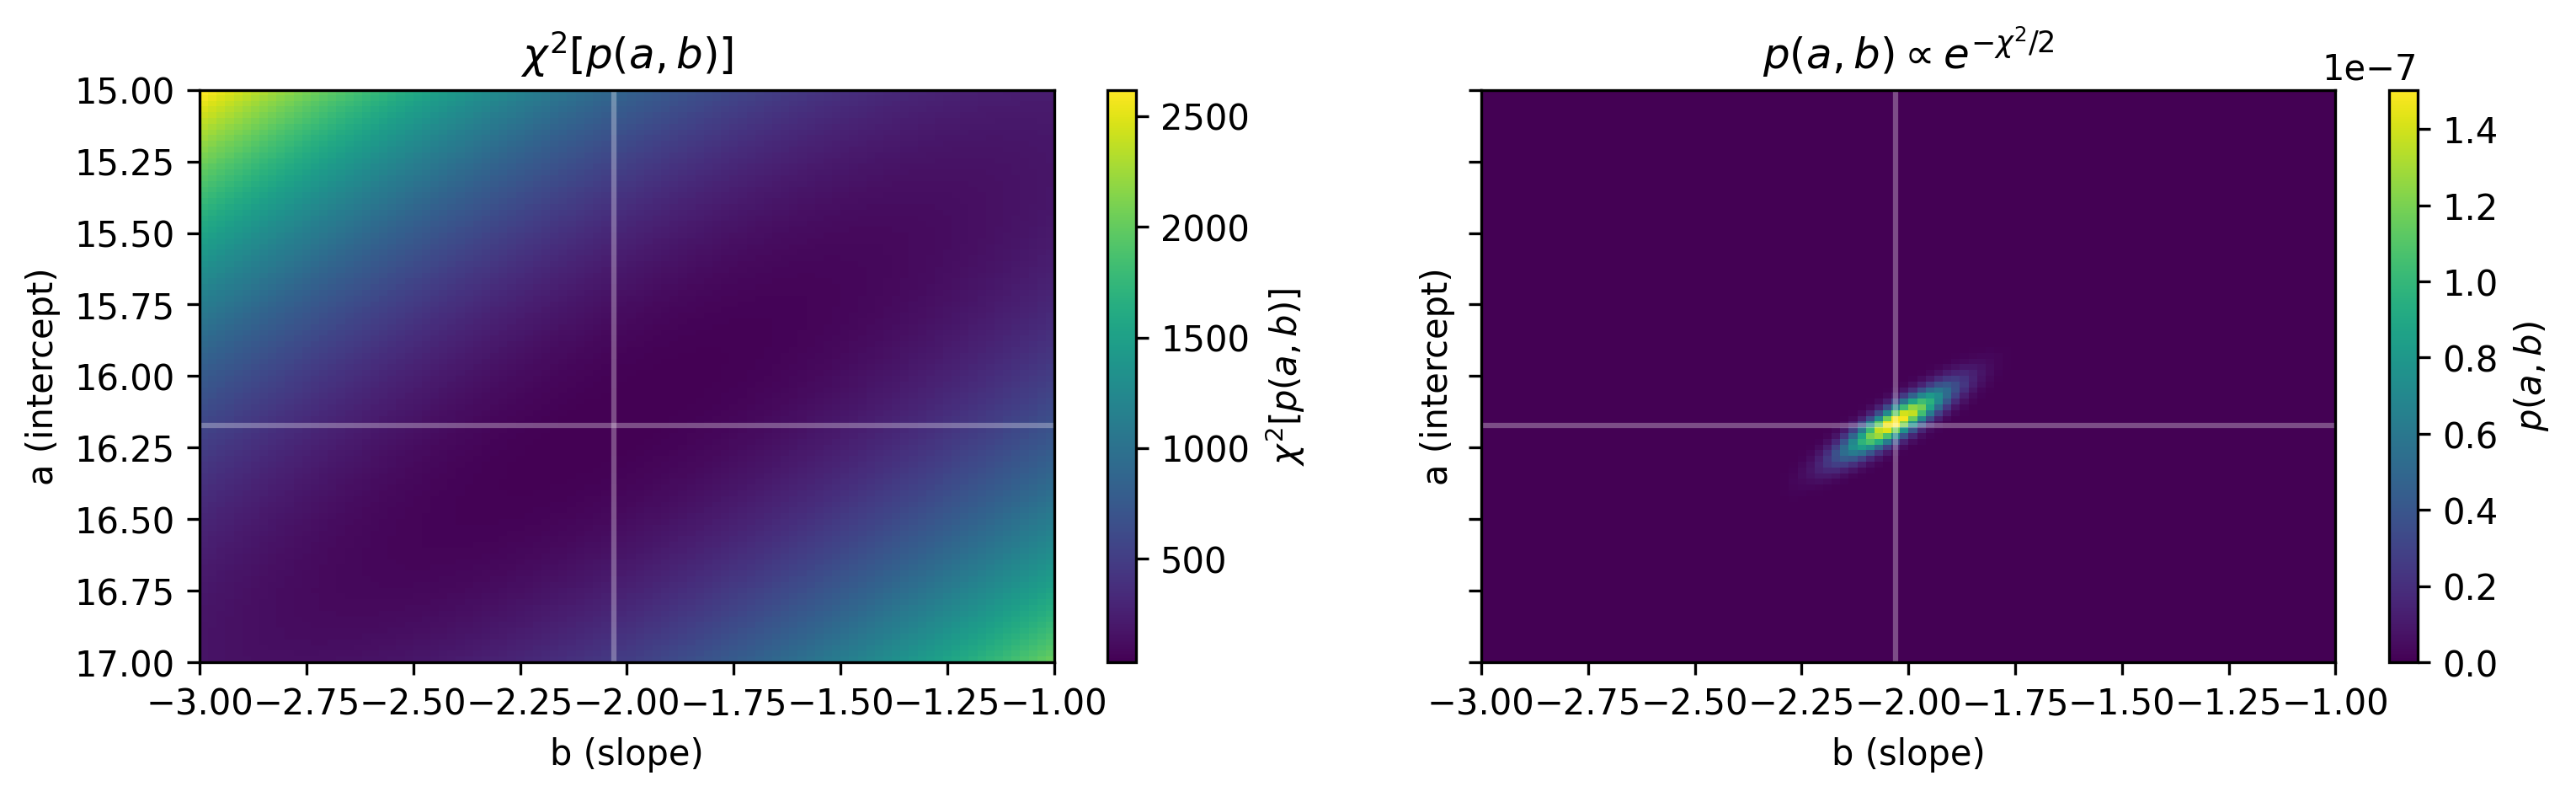

In [174]:
imkw = dict(extent=[np.min(b_explore), np.max(b_explore), np.max(a_explore), np.min(a_explore)], aspect='auto', origin='lower')
fi, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(12,3))

# imshow the log of the probability
plt.sca(ax[0]); plt.imshow(chisq, **imkw); plt.title('$\chi^2[p(a,b)]$')
kw = dict(alpha=0.3, color='white')
plt.axhline(a_best, **kw); plt.axvline(b_best, **kw);
plt.colorbar(label='$\chi^2[p(a,b)]$'); plt.xlabel('b (slope)'); plt.ylabel('a (intercept)')

# imshow the actual probability = exp(log(probability))
plt.sca(ax[1]); plt.imshow(np.exp(-chisq/2), **imkw); plt.title('$p(a,b)\propto e^{-\chi^2/2}$')
plt.axhline(a_best, **kw); plt.axvline(b_best, **kw);
plt.colorbar(label='$p(a,b)$');plt.xlabel('b (slope)'); plt.ylabel('a (intercept)');

The maximum likelihood values of $a$ and $b$ from our grid search seemed to give a pretty good match to the data. (Indeed, they give the best match possible, as defined by the assumptions of our model.)

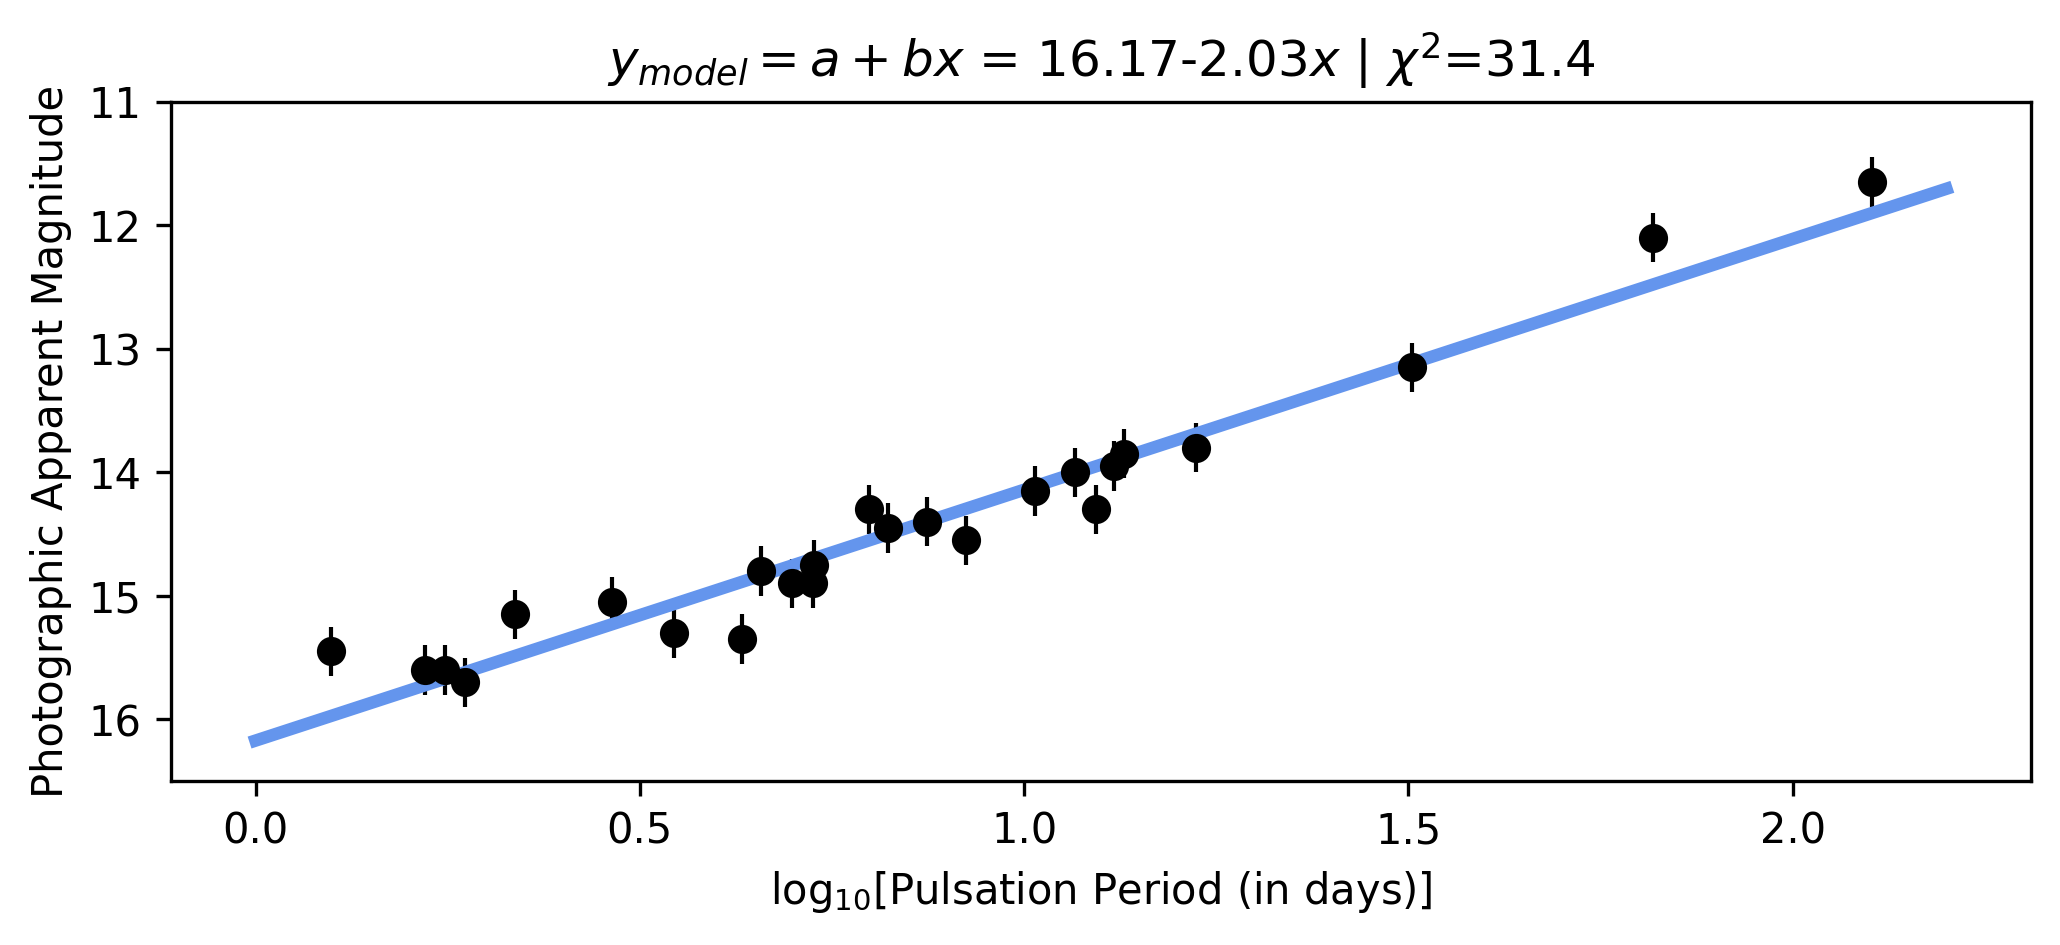

In [175]:
plot_data_and_model(a_best, b_best)

***Note:*** There are much more efficient ways of finding the parameter set that minimizes $\chi^2$ and maximizes the log of the probability, rather than this big grid search. In Python, check out the options like [`np.polyfit`](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html), [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html), [`astropy.modeling`](https://docs.astropy.org/en/stable/modeling/), or others.

For example, let's fit a first-order polynomial (= a line) to these data using the `np.polyfit` tool. It's secretly doing some clever linear algebra to minimize $\chi^2$ very quickly, using the magical methodology of **weighted linear least squares** fitting.

In [181]:
b_polyfit, a_polyfit = np.polyfit(log_period, magnitude, 1)

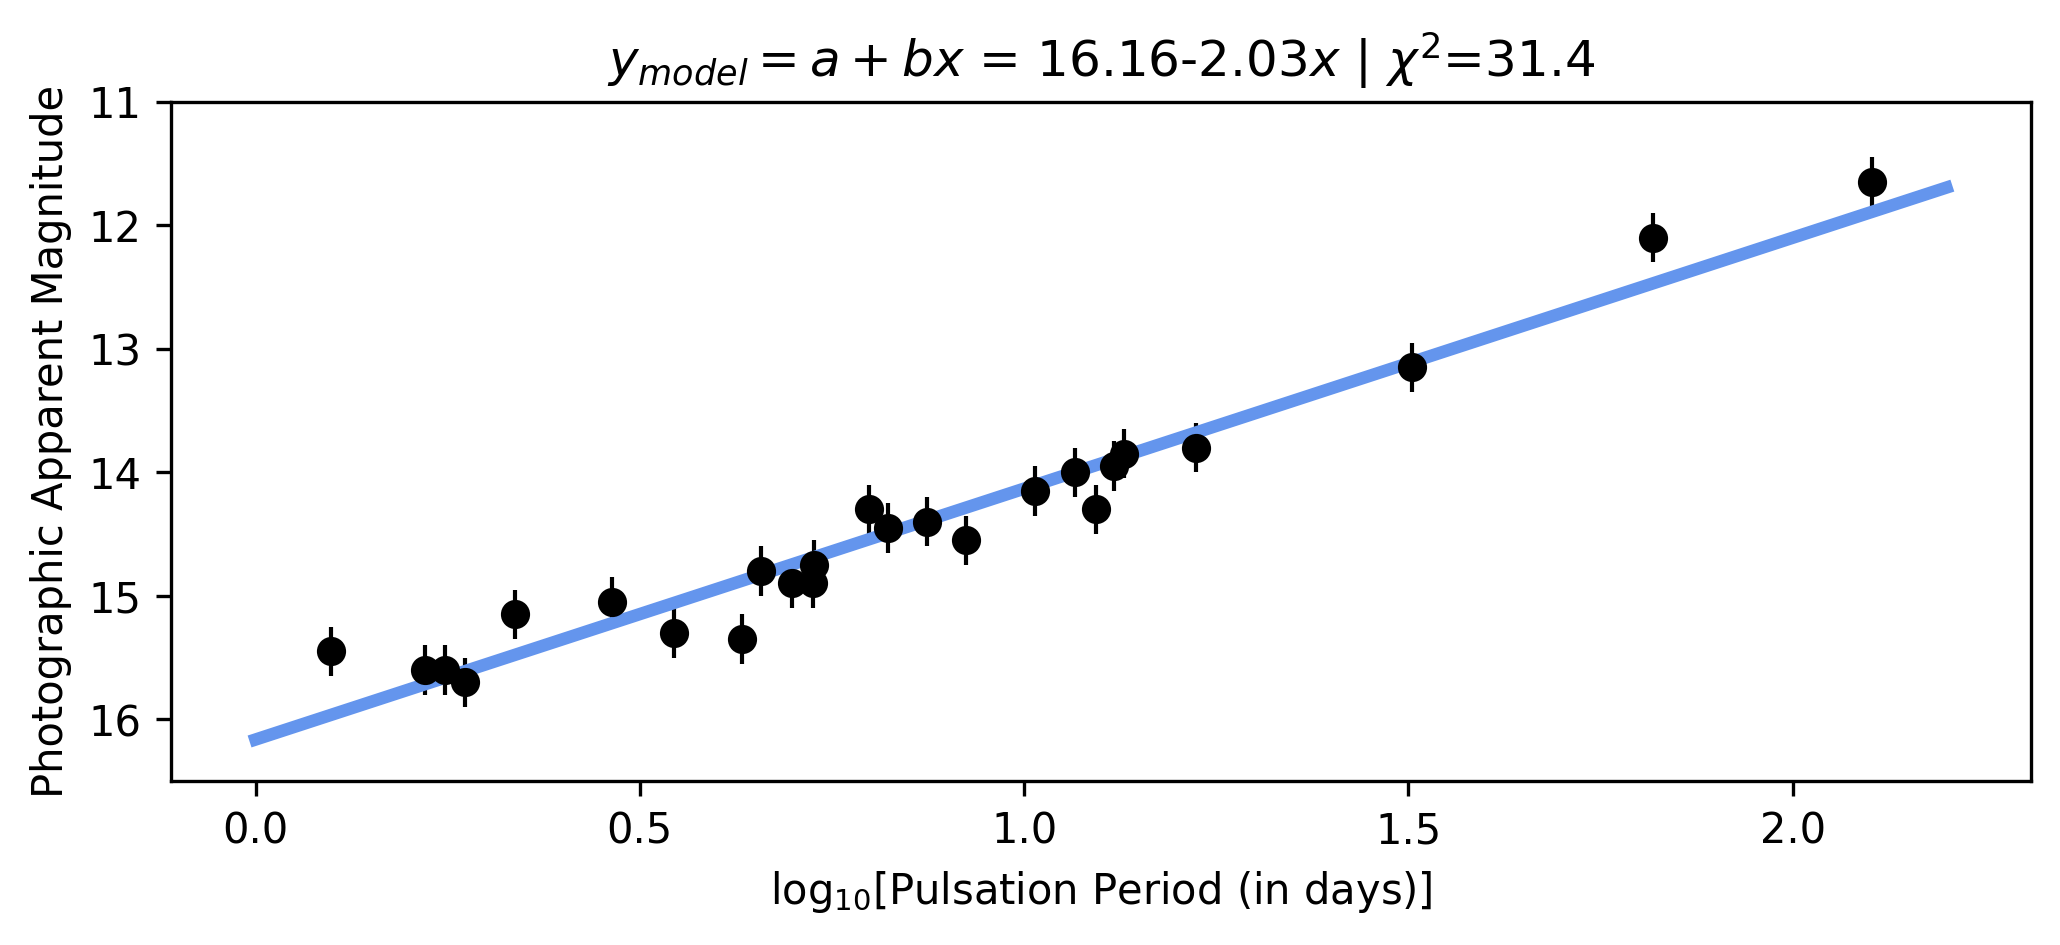

In [182]:
plot_data_and_model(a_polyfit, b_polyfit)

In general, if you want to fit a model to some data, a good starting place is to figure out how to write down the likelihood of your data and then find the parameters that maximize that likelihood!